In [1]:
from reservoir_rls import *
from lorenz63 import *
from sklearn import preprocessing
from scipy.stats import sem
import cma
from scipy.stats import kstest, norm, shapiro
from multiprocessing import Pool
from min_func import *
from tqdm import tqdm
import pandas as pd


from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [ ]:
skiprows = [0]
optim_results = pd.read_csv('outcmaes/fit.dat', sep = ' ' , header = None, skiprows = skiprows)
print(optim_results)
iterations = optim_results.iloc[:,0].to_numpy()
fitness = optim_results.iloc[:,6].to_numpy()
plt.plot(iterations, -fitness*0.05, label = 'CMA-ES')
plt.plot(iterations, 24.5*np.ones(iterations.size)*0.05, '--', label = 'Grid Search Final Result')
plt.xlabel('CMA-ES Generation')
plt.ylabel('Median Valid Prediction Time')
plt.grid()
plt.legend()
plt.xlim(0, 80)
plt.savefig('CMA-ES_fitness_vs_gridsearch.svg')
plt.show()

In [2]:
step = 0.05
start_time = 125
sync_length = 200
num_tests = 500
train_length = 800
pred_length = 400
base_data_length = int(start_time/step)
data_length = int(base_data_length * step/(0.01))+pred_length
r_t = lambda x: r_t_cosine(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)

num_tests = 100
with tqdm(total = num_tests) as pbar:
    for seed in range(num_tests):
        data = getLorenzData(data_length, r_t, dxdt, sample_tau = step, seed = seed)
        if seed == 0:
            optim_data = data[-sync_length - train_length - pred_length:]
        else:
            optim_data = np.vstack((optim_data, data[-sync_length - train_length - pred_length:]))
        pbar.update(1)
print(optim_data.shape)

# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
scaled_data = np.copy(optim_data)
scaled_data = np.ascontiguousarray(scaled_data)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]

(140000, 3)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

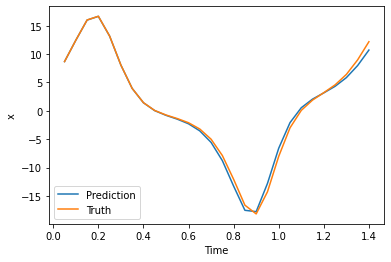

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]

25.0


In [4]:
# res1 = reservoir(3,210,forget = 1 - 10**(-0.5*1.7033347220535784-1.), input_weight = 0.5*(5.034925458824247-5.), LM_regularization = 10.**(-3/5*8.127440233741256-6.), \
#      t_regularization = 0, delta = 1e6, t_weighted = False, RLS_reg_type = 'LM')
res1 = reservoir(3,210,forget = .985, input_weight = 0.01, LM_regularization = 1e-10, \
     t_regularization = 0, delta = 1e6, t_weighted = False, RLS_reg_type = 'LM')
valid_times_norm = cross_validation_performance_separated(scaled_data,res1,num_tests, sync_length, \
               train_length, pred_length, train_method = 'RLS', progress = True)
print(np.median(valid_times_norm))

In [ ]:
num_nodes = 210
base_res = reservoir(3,num_nodes,input_weight = 1, spectral_radius = 1, seed = 1)
mask = ['input_weight', 'LM_regularization', 'forget']
x0 = np.array([5.034925458824247, 8.127440233741256, 1.7033347220535784])
min_func = lambda x: vt_min_function_rls(scaled_data, x, mask, base_res.Win, base_res.A, \
     num_tests = num_tests,  num_nodes = num_nodes, pred_length = pred_length, train_length = train_length)
sigma = 0.11952078257325364

In [ ]:
test_reg = 8.5
weights = np.linspace(4,6,20)
forgets = np.linspace(1,4,20)
func_vals = np.zeros((weights.size, forgets.size))

with tqdm(total = weights.size * forgets.size) as pbar:
    for i in range(weights.size):
        for j in range(forgets.size):
            func_vals[i,j] = min_func(np.array([weights[i], test_reg, forgets[j]]))
            np.savetxt('rls_func_vals_reg%e.csv'%test_reg, func_vals, delimiter = ',')
            pbar.update(1)

In [ ]:
opts = cma.CMAOptions()
opts.set('popsize',6*x0.size)
opts.set('bounds', [0,10])
opts.set('seed', 5)
opts.set('verb_filenameprefix','cmaes_rls_startime%d' % start_time)
results = cma.fmin(min_func, x0, sigma, options = opts)

In [ ]:
res2 = reservoir(3,210,forget = 1, input_weight = 0.25*0.05735187596920699, regularization = 10**(-9.310114193664688), seed = 3)
num_tests = 5000
pred_length = 500
train_length = 400
sync_length = 200
valid_times_norm = cross_validation_performance_resync(scaled_data,res2,num_tests,sync_length, \
   train_length, pred_length,train_method = 'Normal', progress = True)
print(np.median(valid_times_norm))

In [ ]:
res1 = reservoir(3,200,forget = 0.995, input_weight = 0.01, LM_regularization = 1e-10, delta = 1e6)
res2 = reservoir(3,200,forget = 1, input_weight = 0.01, regularization = 1e-7)

In [ ]:
data_length = 100000
step = 0.05
r_t = lambda x: r_t_const(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)
data = getLorenzData(data_length, r_t, dxdt, sample_tau = step)

sync_length = 200
num_tests = 500
train_length = 400
pred_length = 400

# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
scaled_data = np.copy(data)
scaled_data = np.ascontiguousarray(scaled_data)

In [ ]:
valid_times_RLS = cross_validation_performance(scaled_data,res1,num_tests,sync_length, \
   train_length, pred_length,train_method = 'RLS')
print(np.median(valid_times_RLS))
valid_times_norm = cross_validation_performance(scaled_data,res2,num_tests,sync_length, \
   train_length, pred_length,train_method = 'Normal')
print(np.median(valid_times_norm))

In [ ]:
res1 = reservoir(3,300,forget = 0.985, input_weight = 0.01, regularization = 1e-8, \
     t_regularization = 5e-5, delta = 1e6, t_weighted = True)

In [ ]:
# valid_times_norm_array = np.loadtxt('Lorenz63Data/valid_times_norm_tweight_forget%f_reg%e_treg%e.csv' \
#     %(res1.forget, res1.regularization, res1.t_regularization), delimiter = ',')

In [ ]:
step = 0.05
base_data_length = 25000
data_length = int(base_data_length * step/(0.01))
r_t = lambda x: r_t_cosine(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)
valid_times_norm_array = np.array([])

sync_length = 1000
num_tests = 300
train_length = 800
pred_length = 200
completed_seeds = valid_times_norm_array.shape[0]

# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
from tqdm import tqdm
with tqdm(total = num_tests) as pbar:
    for seed in range(num_tests):
        data = getLorenzData(data_length, r_t, dxdt, sample_tau = step, seed = seed)
        scaled_data = np.ascontiguousarray(data)
        valid_times_norm = cross_validation_performance_versust(scaled_data,res1,sync_length, \
               train_length, pred_length,pred_gap_length = 100, train_method = 'Normal', progress = False)
        if valid_times_norm_array.size == 0:
            valid_times_norm_array = np.copy(valid_times_norm)
        else:
            valid_times_norm_array = np.vstack((valid_times_norm_array,valid_times_norm))
        np.savetxt('Lorenz63Data/valid_times_norm_tweight_forget%f_reg%e_treg%e.csv' %(res1.forget, res1.regularization, res1.t_regularization), \
            valid_times_norm_array, delimiter = ',')
        pbar.update(1)

In [ ]:
np.savetxt('Lorenz63Data/valid_times_norm_tweight_forget%f_reg%e_treg%e.csv' %(res1.forget, res1.regularization, res1.t_regularization), \
    valid_times_norm_array, delimiter = ',')

In [ ]:
plt.plot(np.mean(valid_times_norm_array*0.05,axis = 0))
plt.ylim(0,5)
plt.show()

In [ ]:
res1 = reservoir(3,300,forget = 0.985, input_weight = 0.01, LM_regularization = 1e-10, \
     t_regularization = 0, delta = 1e6, t_weighted = False, RLS_reg_type = 'LM')
step = 0.05
base_data_length = 5000
data_length = int(base_data_length * step/(0.01))
r_t = lambda x: r_t_cosine(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)
valid_times_norm_array = np.array([])

sync_length = 500
num_tests = 100
train_length = 2000
pred_length = 400

In [ ]:
data = getLorenzData(data_length, r_t, dxdt, sample_tau = step, seed = 1)
new_data = np.ascontiguousarray(data)

In [ ]:
res1.trainWoutRLS(scaled_data[2800:3800],200)
res1.valid_time(scaled_data[3800:4200],plot = True, error_bound = 3.2)

In [ ]:
valid_times_norm = cross_validation_performance_separated(scaled_data,res1,sync_length, \
               train_length, pred_length, train_method = 'RLS', progress = False)
print(np.median(valid_times_norm))

In [ ]:
# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
from tqdm import tqdm
with tqdm(total = num_tests) as pbar:
    for seed in range(num_tests):
        data = getLorenzData(data_length, r_t, dxdt, sample_tau = step, seed = seed)
        scaled_data = np.ascontiguousarray(data)
        valid_times_norm = cross_validation_performance_versust(scaled_data,res1,sync_length, \
               train_length, pred_length,pred_gap_length = 100, train_method = 'RLS', progress = False)
        if valid_times_norm_array.size == 0:
            valid_times_norm_array = np.copy(valid_times_norm)
        else:
            valid_times_norm_array = np.vstack((valid_times_norm_array,valid_times_norm))
        np.savetxt('Lorenz63Data/valid_times_rls_tweight_forget%f_reg%e_treg%e.csv' %(res1.forget, \
            res1.regularization, res1.t_regularization), valid_times_norm_array, delimiter = ',')
        pbar.update(1)

In [ ]:
plt.plot(np.mean(valid_times_norm_array*0.05,axis = 0))
plt.ylim(0,5)
plt.show()

In [ ]:
x = np.array([[1,2],[3,4]])
np.mean(x,axis = 1)